In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.layers import Conv2D,Conv2DTranspose,Dense,MaxPool2D,Concatenate,Activation,BatchNormalization,Input
from keras.models import Model,Input,load_model,save_model

# Download data

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manavgarg663","key":"3bed30e5542142d3dd8eb6ffcfa5cf4d"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d balraj98/duts-saliency-detection-dataset

 99% 387M/392M [00:02<00:00, 164MB/s]
100% 392M/392M [00:02<00:00, 165MB/s]


In [ ]:
! unzip /content/duts-saliency-detection-dataset.zip -d train

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf

import os
import matplotlib.pyplot as plt
import cv2

import gc 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input,concatenate,BatchNormalization,MaxPooling2D,Concatenate,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Flatten, Dense,Dropout,GlobalAveragePooling2D

In [3]:
image_dir = directory = '/content/train/DUTS-TR/DUTS-TR-Image'
mask_dir = '/content/train/DUTS-TR/DUTS-TR-Mask'

In [4]:
def preprocessing(image_name):
    image = os.path.join(image_dir,image_name) + '.jpg'
    mask = os.path.join(mask_dir,image_name) + '.png'
    
    image = plt.imread(image)
    mask = plt.imread(mask)
    mask = mask.reshape((*mask.shape,1))
    
    image = np.array(tf.image.resize(image,size=(128,128)))
    mask =  np.array(tf.image.resize(mask,size=(128,128)))
    
    image/=255.0
    
    image = image.astype(np.float32)
    mask = mask.astype(np.float32)
    
    return image,mask

In [5]:
image,mask = preprocessing('ILSVRC2012_test_00000004')

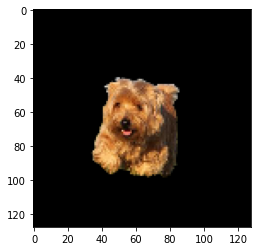

In [6]:
plt.imshow(image*mask)

In [7]:
def generate_data():
    images_name_list = os.listdir('/content/train/DUTS-TR/DUTS-TR-Image')

    images_name_list = list(map(lambda x : x[:-4],images_name_list))

    images_name_list.sort()
    
    images = []
    masks = []
    
    for image_name in images_name_list:
        
        image,mask = preprocessing(image_name)
        if image.shape[0] != 128 or mask.shape[0] != 128:
            continue
        
        images.append(image)
        masks.append(mask)
    
    return np.array(images),np.array(masks)

In [8]:
X,y = generate_data()

# Build Model

In [9]:
from keras import models, layers
# Build U-Net model
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

upsample=upsample_simple
    
input_img = layers.Input((128,128,3), name = 'RGB_Input')
pp_in_layer = input_img

pp_in_layer = layers.AvgPool2D((1, 1))(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(0.1)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.UpSampling2D((1, 1))(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])

In [10]:
seg_model.compile(optimizer='adam',metrics=["accuracy"],loss='binary_crossentropy')

In [11]:
seg_model.fit(X,y,batch_size=64,epochs=10,validation_split=0.15)

Epoch 1/10
141/141 [==============================] - 43s 222ms/step - loss: 0.4648 - accuracy: 0.7314 - val_loss: 0.4638 - val_accuracy: 0.7708
Epoch 2/10
141/141 [==============================] - 29s 208ms/step - loss: 0.3812 - accuracy: 0.7983 - val_loss: 0.3696 - val_accuracy: 0.8112
Epoch 3/10
141/141 [==============================] - 29s 208ms/step - loss: 0.3060 - accuracy: 0.8393 - val_loss: 0.3060 - val_accuracy: 0.8417
Epoch 4/10
141/141 [==============================] - 29s 208ms/step - loss: 0.2637 - accuracy: 0.8597 - val_loss: 0.2691 - val_accuracy: 0.8593
Epoch 5/10
141/141 [==============================] - 29s 207ms/step - loss: 0.2432 - accuracy: 0.8689 - val_loss: 0.2552 - val_accuracy: 0.8661
Epoch 6/10
141/141 [==============================] - 29s 207ms/step - loss: 0.2315 - accuracy: 0.8741 - val_loss: 0.2359 - val_accuracy: 0.8738
Epoch 7/10
141/141 [==============================] - 29s 207ms/step - loss: 0.2198 - accuracy: 0.8791 - val_loss: 0.2347 - val_ac

In [12]:
seg_model.save('unet.h5')

In [13]:
seg_model.save_weights('unet_weights.h5')

In [14]:
m = tf.keras.models.load_model('/content/unet.h5')